# Q Learner Example

In this notebook, we have provided the code which produces a very basic simulation of 3 states: low demand, medium demand, and high demand.
We then use a Q learner to find the optimal prices for these 3 states where the action space ranges from £30 to £60

Play around with the hyperparameter values, what epsiode do we start to converge? (can you do better?), what are the optimal prices?

In [80]:
import numpy as np
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import tqdm
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Load the INI file
config.read('do_not_read.ini')  # Replace 'your_ini_file.ini' with the actual file path

# DO NOT PRINT THESE! THESE ARE THE TARGET VALUES
low_demand_price = config.getfloat('desired_prices', 'low_demand')
medium_demand_price = config.getfloat('desired_prices', 'medium_demand')
high_demand_price = config.getfloat('desired_prices', 'high_demand')

Define a Q learner class

In [81]:
# Q-Learner class with state-action preferences and mean revenue tracking
@dataclass
class QLearner:
    """
    Q learner class
    """
    num_states: int
    num_actions: int
    learning_rate: float
    discount_factor: float
    exploration_prob: float

    current_state: int = 0
    current_episode: int = 0

    def __post_init__(self):
        self.q_table = np.zeros((self.num_states, self.num_actions))
        self.state_action_count = np.zeros((self.num_states, self.num_actions))
        self.mean_revenue = np.zeros(self.num_states)

    def choose_action(self):
        if random.random() < self.exploration_prob:
            return random.randint(0, self.num_actions - 1)
        return np.argmax(self.q_table[self.current_state])

    def update_q_table(self, state, action, reward):
        old_q_value = self.q_table[state][action]
        new_q_value = (1 - self.learning_rate) * old_q_value + self.learning_rate * (reward + self.discount_factor * np.max(self.q_table[state]))
        self.q_table[state][action] = new_q_value

        # Increment the state-action count and update mean revenue
        self.state_action_count[state][action] += 1
        self.mean_revenue[state] += (reward - self.mean_revenue[state]) / self.state_action_count[state][action]

    def set_state(self, state):
        self.current_state = state

Define helper functions for the simulation and q learner

In [82]:
# Function to map customer demand to states integer
def map_demand_to_state(demand):
    """
    Function to map actual demand to demand state

    :param demand: actual demand value
    :return: integer corresponding to q table element of state
    """
    if demand < 400:
        return 0  # Low Demand
    elif demand < 700:
        return 1  # Moderate Demand
    else:
        return 2  # High Demand

def map_price_to_action(price, possible_prices: list):
    """
    Function to map the actual price to the action dimension
    finds the element of price in possible prices

    :param price: actual price set by q learner
    :return: integer corresponding to q table action element
    """
    return possible_prices.index(price)


# Function to determine whether a customer buys based on price difference
def customer_buys(offered_price, desired_price, desired_price_std=1):
    """
    Does the customer purchase at the offered price?

    :param offered_price: offered price from q learning
    :param desired_price: mean desired price of customer
    :param desired_price_std: std to add variance in our customers
    :return: boolean, does the customer buy or not?
    """
    desired_price_random = np.random.normal(desired_price, desired_price_std)
    return offered_price <= desired_price

What are the optimal prices? (Please do not look at these)

In [84]:
# Define state preferences for prices
desired_prices = {
    0: low_demand_price,  # Low Demand State prefers lower prices
    1: medium_demand_price,  # Moderate Demand State prefers moderate prices
    2: high_demand_price   # High Demand State prefers higher prices
}

### Run Episodes

In [85]:
num_episodes, days_per_episode = 1000, 100
num_states, num_actions, learning_rate, discount_factor, exploration_prob = 3, 31, 0.2, 0.0, 0.3
q_learner = QLearner(num_states, num_actions, learning_rate, discount_factor, exploration_prob)
possible_prices = np.arange(30,61,1)
total_revenue_list = []

# Outer loop for episodes
for episode in tqdm.tqdm(range(num_episodes)):
    # keep track of total revenue in an episode
    total_revenue = 0
    for day in range(days_per_episode):
        # simulate customers per day, increases closer to termination
        num_customers_day = int(np.round((day / days_per_episode) ** 2 * 1000))
        # Determine the current state based on the number of customers
        current_state = map_demand_to_state(num_customers_day)
        # set state in q learner
        q_learner.set_state(current_state)
        # daily revenue counter
        daily_revenue = 0
        # Decide whether to explore or exploit
        random_num = random.random()
        if random_num < q_learner.exploration_prob:
            # explore random price. Should be able to offer ANY price that we want to learn about
            offered_price = random.choice(possible_prices)
        else:
            # exploit. Find current best price for this state and offer that
            offered_price = possible_prices[np.argmax(q_learner.q_table[current_state])]
        # loop over each customer in this day
        for _ in range(num_customers_day):
            # desired price of this customer
            buy_or_not = customer_buys(offered_price=offered_price,
                                       desired_price=desired_prices[current_state]
                                       )
            # does the customer buy at this price?
            if buy_or_not:
                daily_revenue += offered_price

        # update total revenue
        total_revenue += daily_revenue

        # update q table
        action = map_price_to_action(offered_price, list(possible_prices))
        if num_customers_day != 0:
            q_learner.update_q_table(current_state, action, daily_revenue / num_customers_day)

    # keep track of revenue per episode
    total_revenue_list.append(total_revenue)


100%|██████████| 1000/1000 [00:39<00:00, 25.44it/s]


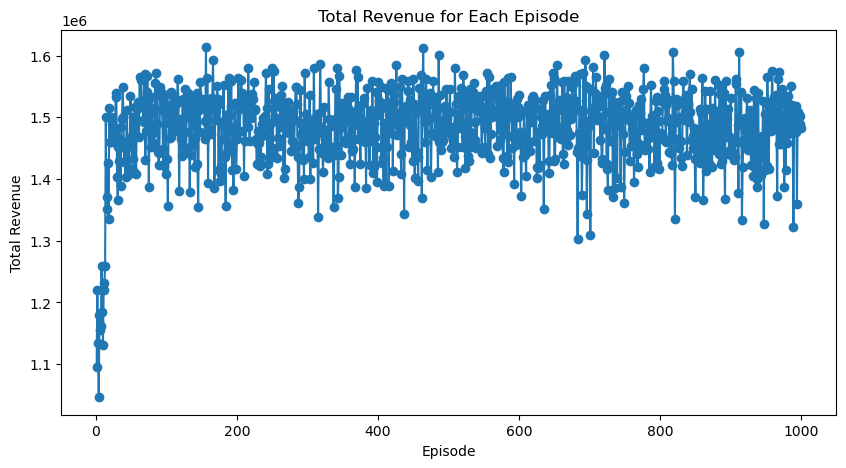

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_episodes + 1), total_revenue_list, marker='o')
plt.title("Total Revenue for Each Episode")
plt.xlabel("Episode")
plt.ylabel("Total Revenue")
plt.show()

### What is the optimal price for each state?

In [93]:
print(f"The optimal price for low demand states is {possible_prices[np.argmax(q_learner.q_table[0])]}")
print(f"The optimal price for medium demand states is {possible_prices[np.argmax(q_learner.q_table[1])]}")
print(f"The optimal price for high demand states is {possible_prices[np.argmax(q_learner.q_table[2])]}")

The optimal price for low demand states is 40
The optimal price for medium demand states is 50
The optimal price for high demand states is 60
